In [1]:
!pip install scikit-tda[all]
!pip install kmapper

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

In [42]:
import random

def get_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloader.dataset.targets == digit]
    return digit_images[:num_samples].view(num_samples, -1)

def sample_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloader.dataset.targets == digit]
    random_indices = random.sample(range(len(digit_images)), num_samples)
    return digit_images[random_indices].view(num_samples, -1)

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


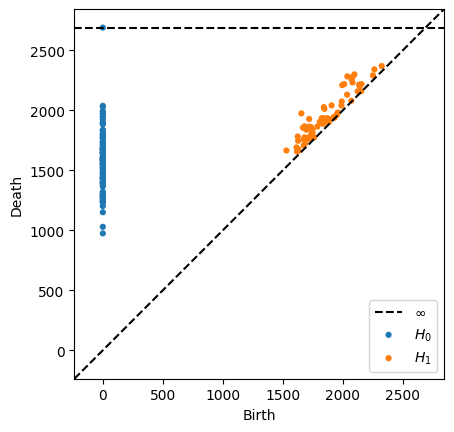

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


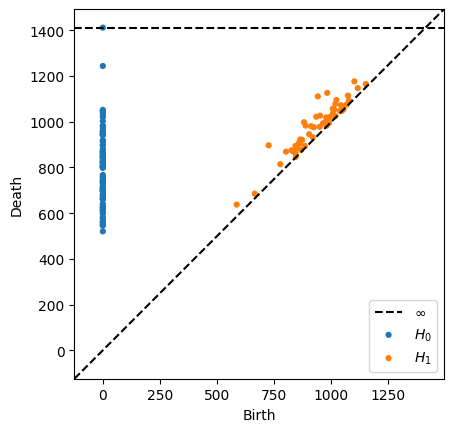

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


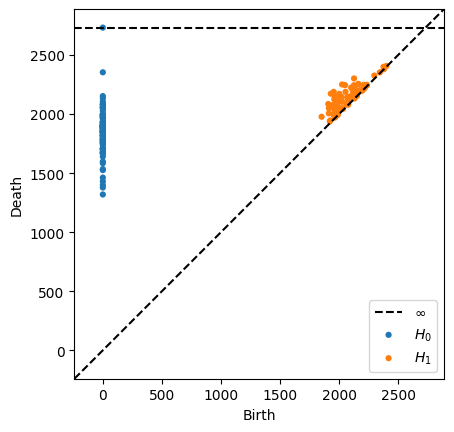

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


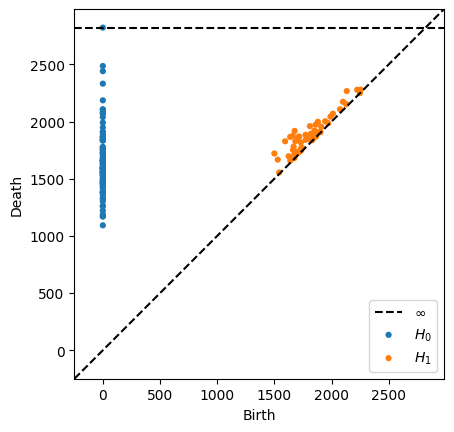

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


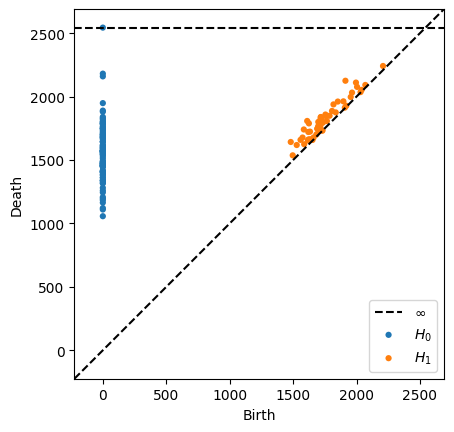

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


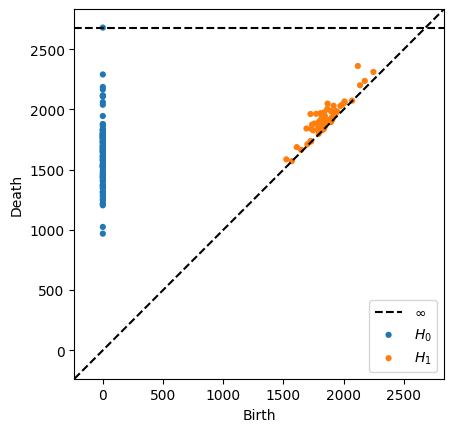

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


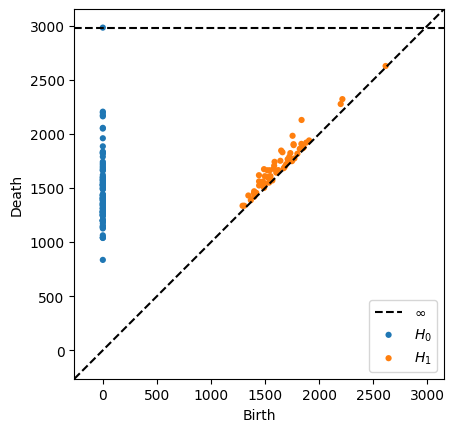

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


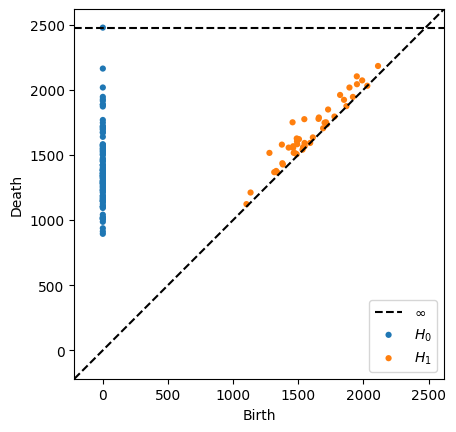

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


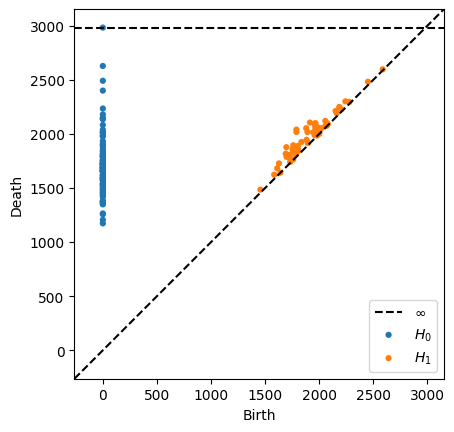

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


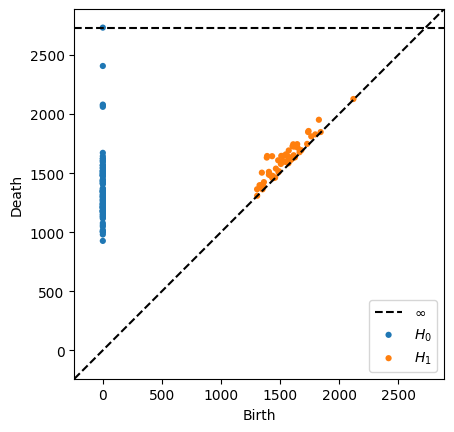

In [46]:
from ripser import ripser
from persim import plot_diagrams

for i in range(10):
    points = sample_digit_subset(data_loader, i, num_samples=100)
    diagrams = ripser(points, maxdim=1)['dgms']
    plot_diagrams(diagrams, show=True)

Individually samples tend to be 1 major connected component with no other structure

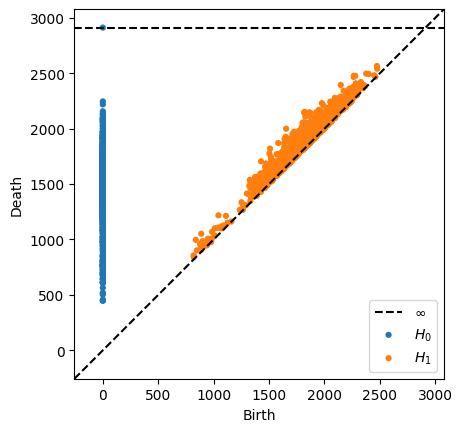

In [53]:
points = [sample_digit_subset(data_loader, i, num_samples=100) for i in range(10)]
points = torch.cat(points)

diagrams = ripser(points, maxdim=1)['dgms']
plot_diagrams(diagrams, show=True)

In [176]:
points = []
labels = []

for i in range(10):
    digit_points = sample_digit_subset(data_loader, i, num_samples=100)
    points.append(digit_points)
    labels += [i] * 100  # add 100 labels for digit i

points = torch.cat(points).numpy() / 255.0  # Normalize
labels = np.array(labels)


In [193]:
import kmapper as km
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

points_reduced = PCA(n_components=50).fit_transform(points)

mapper = km.KeplerMapper(verbose=1)

graph = mapper.map(
    X=points_reduced,

    # lens = mapper.fit_transform(points, projection=PCA(n_components=2))
    lens = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2).fit_transform(points),
    # lens = PCA(n_components=2).fit_transform(points_reduced),

    # cover = km.Cover(n_cubes=6, perc_overlap=0.6),
    # cover = km.Cover(n_cubes=10, perc_overlap=0.4),
    # cover = km.Cover(n_cubes=5, perc_overlap=0.7),
    cover=km.Cover(n_cubes=8, perc_overlap=0.5),


    # clusterer = DBSCAN(eps=0.75, min_samples=2),
    # clusterer = DBSCAN(eps=0.3, min_samples=3)
    # clusterer = DBSCAN(eps=3.0, min_samples=2)
    clusterer=DBSCAN(eps=5.0, min_samples=2)

)

KeplerMapper(verbose=1)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Mapping on data shaped (1000, 50) using lens shaped (1000, 2)

Creating 64 hypercubes.

Created 371 edges and 220 nodes in 0:00:00.144974.


In [194]:
from google.colab import files
mapper.visualize(
    graph,
    path_html="mnist_mapper.html",
    color_values=labels,
    color_function_name=["Digit Label"],
    title="MNIST Mapper with Label Tooltips"
)
files.download('mnist_mapper.html')

Wrote visualization to: mnist_mapper.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
import networkx as nx

# Initialize NetworkX graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(graph['nodes'].keys())

# Convert 'links' dict into list of edge tuples
edges = []
for src, targets in graph['links'].items():
    for tgt in targets:
        edges.append((src, tgt))

G.add_edges_from(edges)

# Get connected components
components = list(nx.connected_components(G))
componentLabels = []

# Analyze each connected component
for i, component in enumerate(components):
    all_indices = []
    for node_id in component:
        all_indices.extend(graph['nodes'][node_id])

    node_labels = labels[all_indices]
    unique, counts = np.unique(node_labels, return_counts=True)
    componentLabels.append(unique.tolist())

    print(f"Component {i} ({len(component)} nodes):")
    for label, count in zip(unique, counts):
        print(f"  Digit {label}: {count} samples")
    print()


Component 0 (62 nodes):
  Digit 0: 126 samples
  Digit 1: 396 samples
  Digit 2: 52 samples
  Digit 3: 190 samples
  Digit 4: 188 samples
  Digit 5: 82 samples
  Digit 6: 288 samples
  Digit 7: 224 samples
  Digit 8: 16 samples
  Digit 9: 260 samples

Component 1 (4 nodes):
  Digit 0: 8 samples

Component 2 (2 nodes):
  Digit 0: 4 samples

Component 3 (2 nodes):
  Digit 0: 6 samples

Component 4 (2 nodes):
  Digit 0: 10 samples

Component 5 (2 nodes):
  Digit 0: 14 samples

Component 6 (4 nodes):
  Digit 0: 20 samples

Component 7 (2 nodes):
  Digit 0: 4 samples

Component 8 (4 nodes):
  Digit 0: 12 samples

Component 9 (6 nodes):
  Digit 3: 24 samples

Component 10 (4 nodes):
  Digit 5: 12 samples

Component 11 (4 nodes):
  Digit 3: 20 samples

Component 12 (2 nodes):
  Digit 5: 4 samples

Component 13 (4 nodes):
  Digit 6: 8 samples

Component 14 (4 nodes):
  Digit 6: 12 samples

Component 15 (4 nodes):
  Digit 0: 4 samples
  Digit 3: 4 samples

Component 16 (4 nodes):
  Digit 6: 8 s

In [180]:
def get_component_images(component, label_filter=None):
    all_indices = []
    for node_id in component:
        all_indices.extend(graph["nodes"][node_id])

    if label_filter is not None:
        all_indices = [i for i in all_indices if labels[i] == label_filter]

    return points[all_indices], labels[all_indices]

def plot_digit_images(images, title="", max_images=25):
    plt.figure(figsize=(10, 4))
    for i in range(min(len(images), max_images)):
        plt.subplot(2, int(max_images/2), i+1)
        plt.imshow(images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

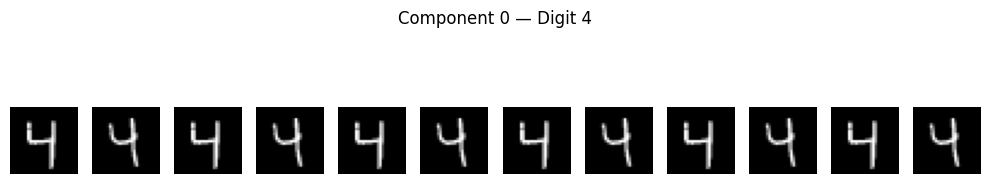

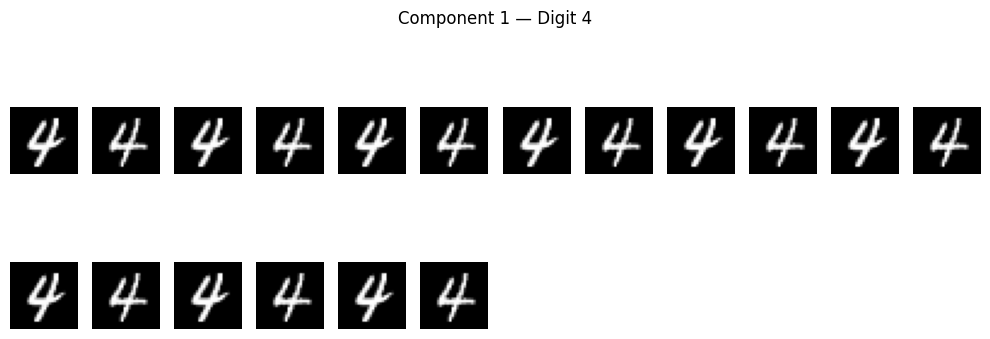

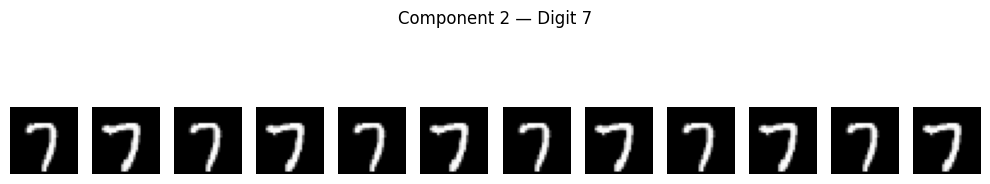

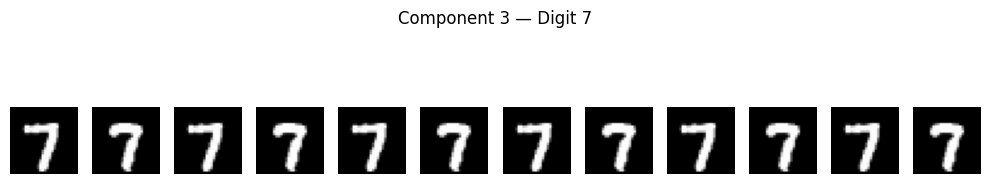

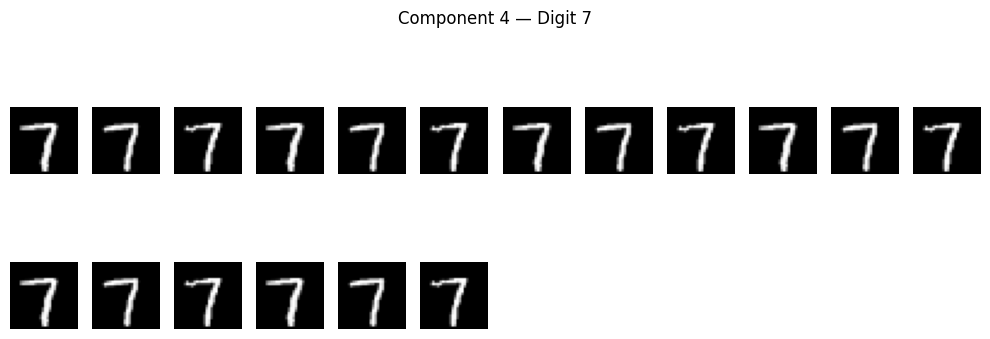

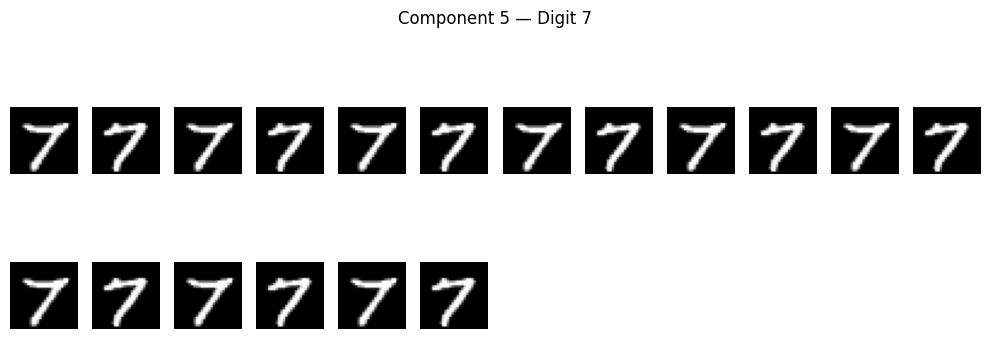

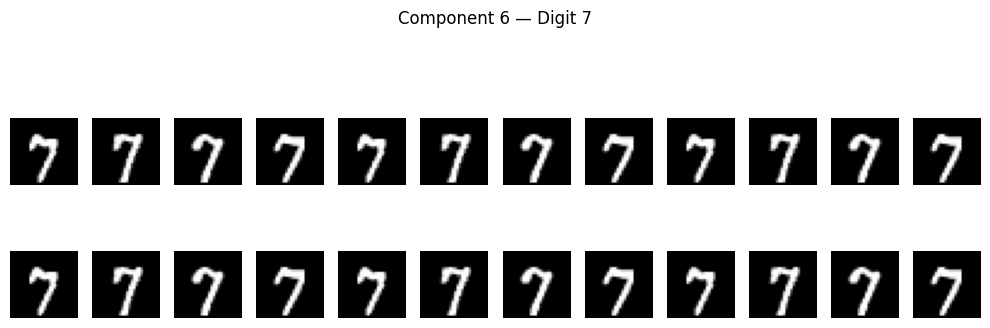

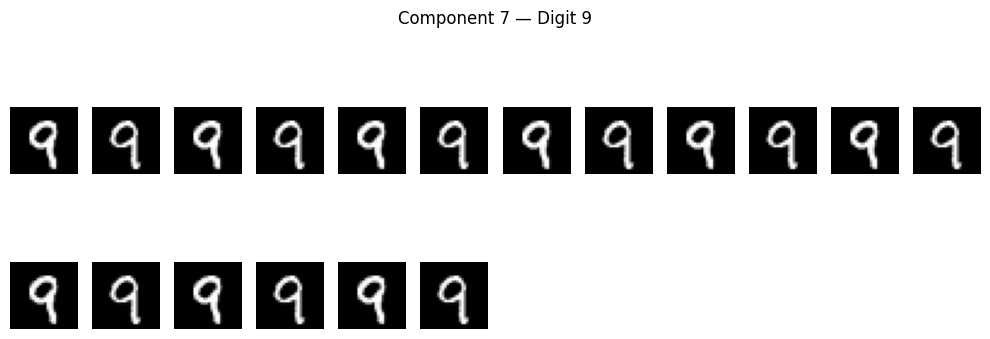

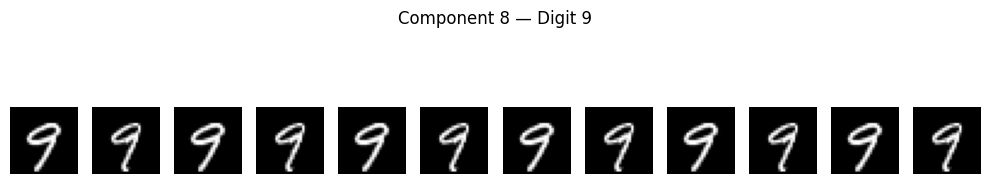

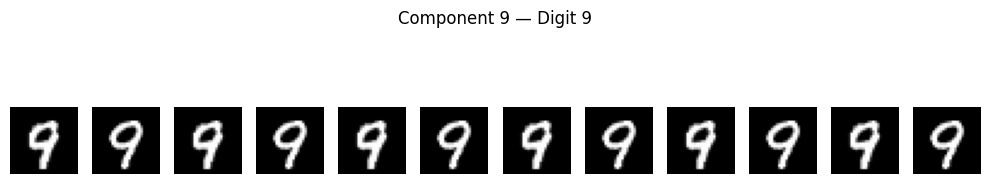

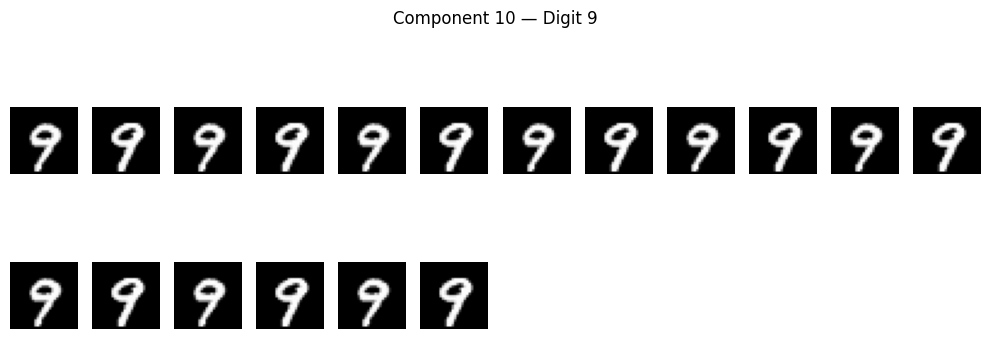

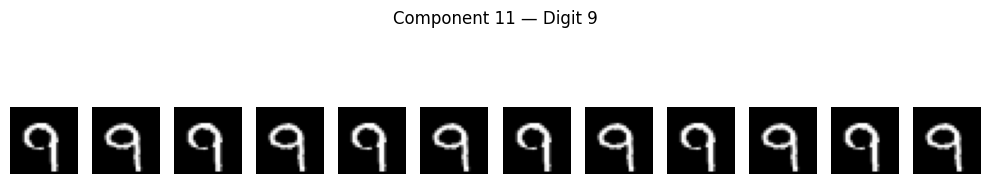

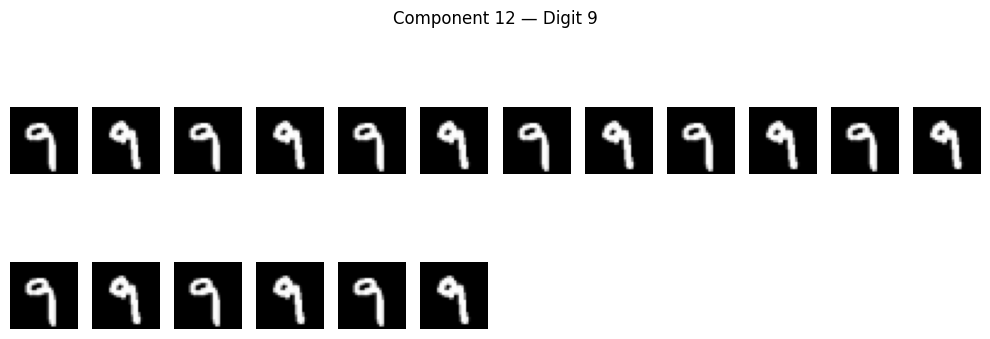

[1, 7]


ValueError: num must be an integer with 1 <= num <= 24, not 25

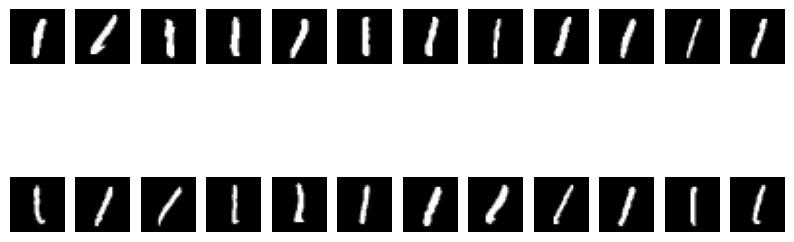

In [181]:
for idx,i in enumerate(componentLabels):
    if len(i) > 1:
        print(i)

    componentImages, imageLabels = get_component_images(components[idx], label_filter=i[0])
    plot_digit_images(componentImages, title=f"Component {idx} — Digit {i[0]}")

In [82]:
from google.colab import _message

# Get notebook JSON data
nb = _message.blocking_request('get_ipynb')['ipynb']

# Extract and print code from all cells
for i, cell in enumerate(nb['cells']):
    if cell['cell_type'] == 'code':
        print(f"### CELL {i} ###")
        print(''.join(cell['source']))
        print("\n--- CELL SEPARATOR ---\n")

### CELL 0 ###
!pip install scikit-tda[all]
!pip install kmapper

--- CELL SEPARATOR ---

### CELL 1 ###
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
def get_data_loader(batch_size=128):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

data_loader = get_data_loader()

--- CELL SEPARATOR ---

### CELL 2 ###
import random

def get_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloader.dataset.targets == digit]
    return digit_images[:num_samples].view(num_samples, -1)

def sample_digit_subset(dataloader, digit=0, num_samples=1000):
    digit_images = dataloader.dataset.data[dataloa